# Lab 1. Floating point

High Performance Computing, Innopolis University, Spring 2018

In [1]:
# Import common modules and set up cute plots
import math
import numpy as np
from typing import List, Iterable
from IPython.core.display import HTML, display
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('figure', figsize=(10, 6))

# Set up snippet to hide some helper code

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
hide_code_script = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
This cell contains some helper code, click <a href="javascript:code_toggle()">here</a> to show/hide it.''')
hide_cell = lambda: display(hide_code_script)

hide_cell()

## Floating point is suffering

In [2]:
1 + 2 == 3

True

In [3]:
0.1 + 0.2 == 0.3

False

## Limited precision

In practice, floating point has limited precision: ~7 significant decimal digits for `np.float32` (`float` in C/C++) and ~16 significant decimal digits for `np.float64` (`double` in C/C++).

In [4]:
np.float32(0.12345670) == np.float32(0.12345671)

False

In [5]:
np.float32(0.123456780) == np.float32(0.123456781) #!

True

In [6]:
np.float32(12345.6780) == np.float32(12345.6781)

True

In [7]:
np.float64(0.123456780) == np.float64(0.123456781)

False

## Internal representation

In [8]:
# Helper functions
def float32_to_bin(x: float) -> str:
    '''Return binary representation of the float (treated as a single-precision number)'''
    # The `np.float32(x).view(np.uint32).item()` part is akin to `* ((uint32_t*) &x)` in C.
    return '0b{0:032b}'.format(np.float32(x).view(np.uint32).item())

def pretty_print_float(x: float):
    '''Return Jupyter object for pretty-printing binary representation of floats'''
    exp_size = 8  # number of bits in exponent of float32, from IEEE 754 standard
    def _colorize(s: str, color: str) -> str:
        return '<span style="font-family:\'Courier New\';font-weight:bold;color:{1}">{0}</span>'.format(s, color)
    
    bin_repr = float32_to_bin(x)
    prefix, sign, exponent, mantissa = bin_repr[0:2], bin_repr[2:3], bin_repr[3:3+exp_size], bin_repr[3+exp_size:]
    return HTML(
        _colorize(prefix, 'black') +
        _colorize(sign, 'blue') + 
        _colorize(exponent, 'red') + 
        _colorize(mantissa, 'green')
    )
hide_cell()

The function `pretty_print_float` above prints binary representation of 
[IEEE-754](https://en.wikipedia.org/wiki/IEEE_754) 32-bit floating point number.
The sign bit is printed in blue, the exponent in red, and mantissa in green.

In [9]:
pretty_print_float(5.5)

Why?

- 5.5 > 0, so the first bit is **`0b0`**
- Now let's convert it to binary form: `5.5 = 4 + 1 + 0.5 = 2**2 + 2**0 + 2**-1 = 0b101.1`
- Normalize it: `0b101.1 = 0b1.011 * 2**2`
- Raw exponent is 2, but we must add bias, which for `float32` is 127, so exponent is `127 + 2 = 129 = `**`0b10000001`**
- Mantissa is **`0b011`**. We can add zeroes to the end of it, similar to how `0.1 == 0.10000` in decimal.

In [10]:
pretty_print_float(-5.5)  # Sign bit changes here

In [11]:
pretty_print_float(5.5*2)  # Exponent changes here

In [12]:
pretty_print_float(5.25)  # Mantissa changes here (5.5 = 0b101.10; 5.25 = 0b101.01)

In [13]:
pretty_print_float(0.085)  # Detailed explanation at http://class.ece.iastate.edu/arun/CprE281_F05/ieee754/ie4.html

If you want, you can compare the binary representations of 0.12345670 and 0.12345671, 0.123456780 and 0.12345678 that we compared in previous section.

## Summation

### Error accumulation

As we have seen earlier, `0.1 + 0.2 ≠ 0.3`.

When adding many numbers together, rounding errors accumulate:

In [14]:
a = [.1] * 10
print(a)

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


In [15]:
print(0.1*10)

1.0


In [16]:
sum(a)

0.9999999999999999

In such cases, we have to use numerically-stable summation.
Here is the one Python has in its standard library:

In [17]:
math.fsum(a)

1.0

We won't delve deep into `fsum` algorithm, but look more closely at a simpler example: 
[Kahan summation algorithm](https://en.wikipedia.org/wiki/Kahan_summation_algorithm)

In [18]:
def kahan(x: Iterable[float]) -> float:
    '''Compute the Kahan sum of x'''
    acc = 0.0  # Current accumulator
    c = 0.0  # Running compensation for lost low-order bits
    for x_i in x:
        y = x_i - c
        s = acc + y
        c = (s - acc) - y  # Algebraically, t - s - y = s + y - s - y = 0. But we have limited precision.
        acc = s
    return acc

In [19]:
kahan(a)

1.0

Let's look how the compensation terms behave. We will use larger array for clarity:

Array [0.1] * 100
Kahan sum = 10.000000000000000, naïve sum = 9.999999999999980


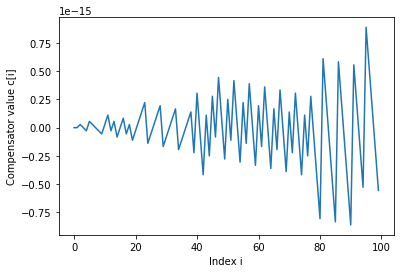

In [20]:
def vis_kahan1():
    '''Compute the Kahan sum of x'''
    x = np.ones((100), dtype=np.float64) * 0.1
    acc = 0.0
    c = np.zeros_like(x)
    y = np.zeros_like(x)
    s = np.zeros_like(x)
    for i, x_i in enumerate(x):
        y[i] = x_i - c[i-1]  # If i==0, c[-1] is the last element, which is still zero
        s[i] = acc + y[i]  # See above
        c[i] = (s[i] - acc) - y[i]
        acc = s[i]
    
    print('Array [0.1] * 100')
    print('Kahan sum = {:.15f}, naïve sum = {:.15f}'.format(acc, sum(x)))
    plt.figure()
    plt.plot(c)
    plt.xlabel('Index i')
    plt.ylabel('Compensator value c[i]')    
    
hide_cell()
vis_kahan1()

### Normalization

When adding two numbers, they must be normalized (converted to have same exponent).
This leads to the loss of precision when adding numbers that differ in magnitude.
Let's look at the example below:

In [21]:
a = np.array([1e8, 1, -1e8], dtype=np.float32)  # Array of three floats
print(a)

[ 1.e+08  1.e+00 -1.e+08]


In [22]:
a.sum()  # Summation is performed using float32's

0.0

In [23]:
a.sum(dtype=np.float64)  # Do the summation using float64 for intermediate values

1.0

In [24]:
sum(a)  # Values are converted into Python internal float type (that is actually float64), so the result is nice again

1.0

The previous example was working fine if we increase precision from single (32 bit) to double (64 bit).

But if the difference between numbers is even greater, this won't help:

In [25]:
a = [1, 1e100, 1, -1e100] * 10000

print('True (algebraic) sum = 20000')
print('Naïve sum = {}'.format(sum(a)))
print('Kahan sum = {}'.format(kahan(a)))
print('Quadruple-precision (float128) sum = {}'.format(np.array(a, dtype=np.float128).sum()))
print('math.fsum = {}'.format(math.fsum(a)))

True (algebraic) sum = 20000
Naïve sum = 0.0
Kahan sum = 0.0
Quadruple-precision (float128) sum = 0.0
math.fsum = 20000.0


As we can see, even Kahan algorithm and [128-bit floating point values](https://en.wikipedia.org/wiki/Quadruple-precision_floating-point_format) are not of use here.
But more elaborate algorithm used in [`math.fsum`](https://docs.python.org/3/library/math.html#math.fsum) helps.

You can also take a look at [Neumaier algorithm](https://en.wikipedia.org/wiki/Kahan_summation_algorithm#Further_enhancements), which is a modification of Kahan algorithm that can deal with such issues.